In [ ]:
import pandas as pd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns

# =========================================================
# 1. CARREGAMENTO DE DADOS
# =========================================================
hotels = pd.read_csv("/content/hotel.csv", encoding_errors="ignore")
airlines = pd.read_csv("/content/airlines_flights_data.csv", encoding_errors="ignore")
city_coords_df = pd.read_csv("/content/world_top100_cities.csv")

# Padroniza nomes
for df in [hotels, airlines, city_coords_df]:
    df.columns = df.columns.str.lower()

rename_map = {
    "rating": "score", "rate": "score", "overall": "score",
    "review_rating": "score", "hotel_rating": "score", "hotel_name": "hotel"
}
hotels = hotels.rename(columns={c: rename_map[c] for c in hotels.columns if c in rename_map})

# Normaliza nomes de cidades
hotels["location_norm"] = hotels["location"].str.lower().str.strip()
airlines["source_city_norm"] = airlines["source_city"].str.lower().str.strip()
airlines["destination_city_norm"] = airlines["destination_city"].str.lower().str.strip()
city_coords_df["city_norm"] = city_coords_df["city"].str.lower().str.strip()

In [ ]:
# =========================================================
# 2. FUNÇÕES DE LÓGICA
# =========================================================
def get_city_coords(city_name):
    row = city_coords_df[city_coords_df["city_norm"] == city_name.lower().strip()]
    return (row.iloc[0]["latitude"], row.iloc[0]["longitude"]) if not row.empty else None

def calc_distance(origin, destination):
    o_coords = get_city_coords(origin)
    d_coords = get_city_coords(destination)
    return geodesic(o_coords, d_coords).km if o_coords and d_coords else None

def estimate_co2(distance_km, co2_input=None, load_factor=0.75):
    co2_full = co2_input if co2_input else distance_km * 0.09 * 150 if distance_km else None
    co2_wasted = co2_full * (1 - load_factor) if co2_full else None
    return co2_full, co2_wasted

def recommend(origin, destination):
    o = origin.lower().strip()
    d = destination.lower().strip()
    df_air = airlines[(airlines["source_city_norm"] == o) & (airlines["destination_city_norm"] == d)]
    airline_name = df_air.sort_values("score", ascending=False).iloc[0]["airline"] if not df_air.empty else None
    df_hot = hotels[hotels["location_norm"] == d]
    hotel_name = df_hot.sort_values("score", ascending=False).iloc[0]["hotel"] if not df_hot.empty else None
    return {"best_airline": airline_name, "best_hotel": hotel_name, "hotels_df": df_hot}

In [ ]:
# =========================================================
# 3. VISUALIZAÇÕES
# =========================================================
def plot_top_hotels(df_hotels, destination):
    if df_hotels.empty:
        print("Nenhum hotel encontrado para visualização.")
        return
    top_hotels = df_hotels.sort_values("score", ascending=False).head(10)
    plt.figure(figsize=(10,6))
    sns.barplot(x="score", y="hotel", data=top_hotels, palette="viridis")
    plt.xlim(top_hotels["score"].min() - 0.2, top_hotels["score"].max() + 0.2)
    for i, v in enumerate(top_hotels["score"]):
        plt.text(v + 0.02, i, f"{v:.2f}", va="center")
    plt.title(f"Top 10 Hotéis em {destination}")
    plt.xlabel("Score")
    plt.ylabel("Hotel")
    plt.tight_layout()
    plt.show()

def plot_co2_comparison(origin, destination, co2_total, occupancy_percent):
    co2_param = co2_total
    co2_q_low = co2_param * 0.75
    co2_q_high = co2_param
    co2_data = pd.DataFrame({
        "Categoria": ["100% Ocupação", f"{occupancy_percent}% Ocupação", "Quartil Inferior", "Quartil Superior"],
        "CO2 per capita (kg)": [co2_total, co2_param, co2_q_low, co2_q_high]
    })
    plt.figure(figsize=(8,5))
    sns.barplot(x="Categoria", y="CO2 per capita (kg)", data=co2_data, palette="coolwarm")
    plt.ylim(co2_q_low * 0.95, co2_total * 1.05)
    for i, v in enumerate(co2_data["CO2 per capita (kg)"]):
        plt.text(i, v + 50, f"{v:.2f}", ha="center")
    plt.title(f"Comparação de CO₂ per capita para voo {origin} → {destination}")
    plt.ylabel("CO₂ per capita (kg)")
    plt.tight_layout()
    plt.show()

def plot_co2_total(co2_total, co2_wasted, origin, destination):
    co2_data_total = pd.DataFrame({
        "Categoria": ["CO2 Total", "CO2 Desperdiçado"],
        "CO2 (kg)": [co2_total, co2_wasted]
    })
    plt.figure(figsize=(8, 4))
    sns.barplot(x="CO2 (kg)", y="Categoria", data=co2_data_total, palette="Reds_r")
    for i, v in enumerate(co2_data_total["CO2 (kg)"]):
        plt.text(v + 50, i, f"{v:.2f} kg", va="center")
    plt.title(f"Emissão de CO₂ para voo {origin} → {destination}")
    plt.xlabel("CO₂ (kg)")
    plt.ylabel("Categoria")
    plt.xlim(0, co2_total * 1.1)
    plt.tight_layout()
    plt.show()

In [ ]:
# =========================================================
# 4. EXECUÇÃO PRINCIPAL
# =========================================================
def interactive_recommendation(origin, destination, occupancy_percent=75, co2_input=None):
    load_factor = occupancy_percent / 100
    rec = recommend(origin, destination)
    distance_km = calc_distance(origin, destination)
    co2_full, co2_wasted = estimate_co2(distance_km, co2_input, load_factor)

    print("\n================ RECOMENDAÇÃO =================")
    print(f"Origem: {origin} | Destino: {destination}")
    print(f"Melhor companhia aérea: {rec['best_airline'] or 'Não encontrado'}")
    print(f"Melhor hotel na cidade de destino: {rec['best_hotel'] or 'Não encontrado'}")
    print(f"Distância estimada: {distance_km:.2f} km" if distance_km else "Distância estimada: Não disponível")
    print(f"CO2 total estimado: {co2_full:.2f} kg" if co2_full else "CO2 total estimado: Não disponível")
    print(f"CO2 desperdiçado: {co2_wasted:.2f} kg" if co2_wasted else "CO2 desperdiçado: Não disponível")
    print(f"Percentual de ocupação do voo: {occupancy_percent}%")
    print("==============================================\n")

    if co2_full:
        plot_co2_total(co2_full, co2_wasted, origin, destination)
    plot_top_hotels(rec["hotels_df"], destination)


================ RECOMENDAÇÃO =================
Origem: São Paulo | Destino: Paris
Melhor companhia aérea: Não encontrado
Melhor hotel na cidade de destino: Htel Madame Rve
Distância estimada: 9378.37 km
CO2 total estimado: 126608.03 kg
CO2 desperdiçado: 101286.43 kg
Percentual de ocupação do voo: 20%



/tmp/ipython-input-1375710680.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="CO2 (kg)", y="Categoria", data=co2_data_total, palette="Reds_r")


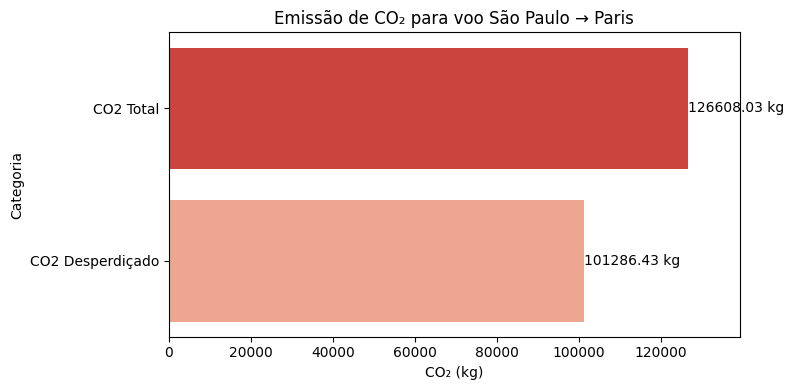

/tmp/ipython-input-1375710680.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="score", y="hotel", data=top_hotels, palette="viridis")


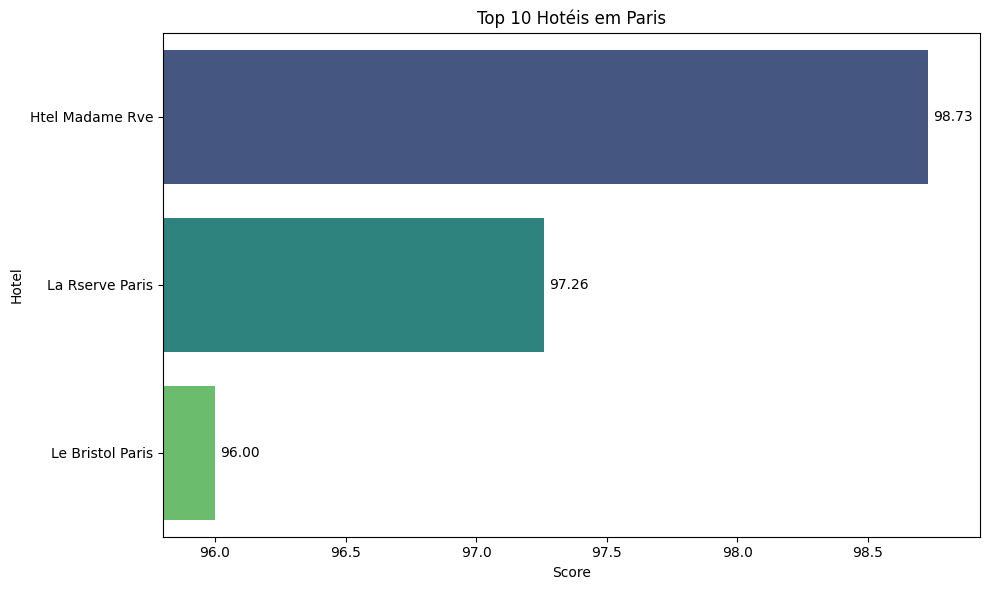

In [ ]:
# =========================================================
# 5. CHAMADA FINAL
# =========================================================
interactive_recommendation("São Paulo", "Paris", occupancy_percent=20)
